# Transporter analysis of bacillus mother-spore

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [36]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [37]:
solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 438.284179 seconds
Finished substituting S,lb,ub in 11.263735 seconds
Finished makeME_LP in 2.234428 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 11.217346 seconds
Finished makeME_LP in 2.226781 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 11.419299 seconds
Finished makeME_LP in 2.219893 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 11.467450 seconds
Finished makeME_LP in 2.236072 seconds
Getting MINOS parameters from ME_NLP...
4 0.09375 0.09375 0.125 0.09375 optimal
Finished substituting S,lb,ub in 11.412444 seconds
Finished makeME_LP in 2.234481 seconds
Getting MINOS parameters from ME_NLP...
5 0.109375 0.109375 0.125 0.109375 optimal
Finished substituting S,lb,ub in 11.342300 seconds
Finished makeME_LP in 2.243705 sec

In [3]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [4]:
# Get transport reactions

def get_compartments(r):
    comps = []
    if isinstance(r,cobrame.MetabolicReaction):
        for m in r.metabolites:
            if isinstance(m,cobrame.Metabolite):
                comps.append(m.id[-1])
    return list(set(comps))

def get_all_transport(model):
    transport_reactions = []
    for r in tqdm(model.reactions):
        comps = get_compartments(r)
        if len(comps) > 1 and 's' in comps:
            transport_reactions.append(r.id)
    return list(set(transport_reactions))

def get_active_transport(transport_reactions):
    active_transporters = []
    for r in tqdm(transport_reactions):
        if 'SPONT' not in r and abs(sporeme.solution.x_dict[r])>0.:
            active_transporters.append(r)
    # Include arginine transport
    arginine_transport = [r.id for r in get_transport_reactions(sporeme,'arg__L_c',comps=['c','s'])+get_transport_reactions(sporeme,'arg__L_c',comps=['s','c'])]
    [active_transporters.append(r) for r in arginine_transport]
    active_transporters = list(set(active_transporters))
    return active_transporters

In [5]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

## Check by group of transporters of metabolite

In [46]:
solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-4,growth_key = 'sigma', verbosity = 2)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 440.220508 seconds
Finished substituting S,lb,ub in 12.258054 seconds
Finished makeME_LP in 2.168828 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 12.075626 seconds
Finished makeME_LP in 2.189026 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 12.112451 seconds
Finished makeME_LP in 2.177423 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 12.054281 seconds
Finished makeME_LP in 2.186527 seconds
Getting MINOS parameters from ME_NLP...
4 0.09375 0.09375 0.125 0.09375 optimal
Finished substituting S,lb,ub in 12.052042 seconds
Finished makeME_LP in 2.181184 seconds
Getting MINOS parameters from ME_NLP...
5 0.109375 0.109375 0.125 0.109375 optimal
Finished substituting S,lb,ub in 11.952905 seconds
Finished makeME_LP in 2.183706 sec

In [6]:
def get_necessary_metabolites(model,active_transporters):
    necessary_metabolites = []
    for r in tqdm(active_transporters):
        rxn = model.reactions.get_by_id(r)
        for m in rxn.products:
            if not isinstance(m,cobrame.Metabolite):
                continue
            met_root = m.id[:-2]
            for i in rxn.reactants:
                if met_root in i.id:
                    necessary_metabolites.append(m.id)
    return list(set(necessary_metabolites))

def get_all_available_transport(model,necessary_metabolites):
    available_transport = []
    at_dict = {}
    for m in tqdm(necessary_metabolites):
        rxns = get_transport_reactions(model,m,comps=['c','s']) + get_transport_reactions(model,m,comps=['s','c'])
        [available_transport.append(r.id) for r in rxns]
        at_dict[m] = []
        [at_dict[m].append(r.id) for r in rxns]
    return list(set(available_transport)), at_dict

In [7]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [8]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

100%|██████████| 12339/12339 [00:00<00:00, 156082.95it/s]

405 transport reactions identified


In [9]:
active_transporters = get_active_transport(transport_reactions)
necessary_metabolites = get_necessary_metabolites(sporeme,active_transporters)
necessary_metabolites.remove('h_s')
necessary_metabolites.remove('h_c')
available_transport, at_dict = get_all_available_transport(sporeme,necessary_metabolites)

100%|██████████| 51/51 [00:01<00:00, 42.77it/s]


In [10]:
print('{} active transport reactions identified'.format(len(active_transporters)))
print('{} necessary metabolites identified'.format(len(necessary_metabolites)))
print('{} available transport reactions identified'.format(len(available_transport)))

54 active transport reactions identified
51 necessary metabolites identified
127 available transport reactions identified


In [11]:
all_transporters_to_open = list(set(active_transporters + available_transport))
print('{} open transport reactions identified'.format(len(all_transporters_to_open)))
print('Included {}'.format(set(active_transporters)-set(available_transport)))

129 open transport reactions identified
Included {'ATPS4r_FWD_CPLX000-10_s', 'GLCpts_FWD_BSU13890-MONOMER_s'}


In [12]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

#### Close PEP shuttle

In [13]:
necessary_metabolites.remove('pep_s')
for r in at_dict['pep_s']:
    sporeme.reactions.get_by_id(r).bounds = (0,0)

In [14]:
necessary_metabolites.remove('pyr_c')
for r in at_dict['pyr_c']:
    sporeme.reactions.get_by_id(r).bounds = (0,0)

In [15]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 452.655037 seconds
Finished substituting S,lb,ub in 12.430493 seconds
Finished makeME_LP in 2.406062 seconds
Getting MINOS parameters from ME_NLP...
1 0.075 0.075 0.15 0.075 optimal
Finished substituting S,lb,ub in 12.774487 seconds
Finished makeME_LP in 2.449258 seconds
Getting MINOS parameters from ME_NLP...
2 0.075 0.075 0.11249999999999999 0.11249999999999999 1
Finished substituting S,lb,ub in 11.831181 seconds
Finished makeME_LP in 2.232360 seconds
Getting MINOS parameters from ME_NLP...
3 0.09375 0.09375 0.11249999999999999 0.09375 optimal
Finished substituting S,lb,ub in 11.910250 seconds
Finished makeME_LP in 2.223287 seconds
Getting MINOS parameters from ME_NLP...
4 0.103125 0.103125 0.11249999999999999 0.103125 optimal
Finished substituting S,lb,ub in 11.715594 seconds
Finished makeME_LP in 2.222601 seconds
Getting MINOS parameters from ME_NLP...
5 0.10781249999999999 0.10781249999999999 0.1124999

In [16]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,necessary_metabolites, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')

Chosen change function: group_knockout      Sequential = False


biomass_dilution_s response (10 threads): 100%|██████████| 49/49 [3:29:04<00:00, 919.25s/it]  

In [17]:
flux_results_df.to_csv('PEP_group_KO_flux_results.csv')

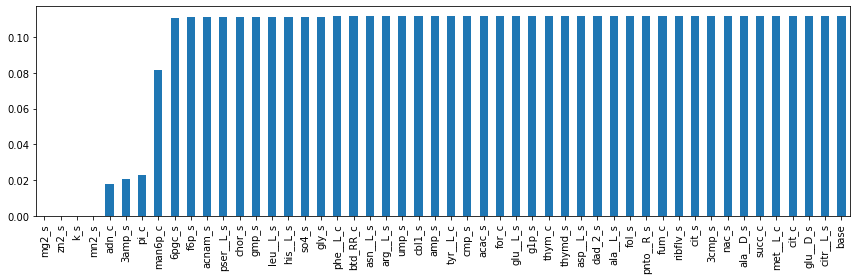

In [18]:
flux_results_df = pd.read_csv('PEP_group_KO_flux_results.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("PEP_group_KO_flux_results.svg", format="SVG")

### Close metabolite one by one
Including information about arginine being transported

In [19]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [20]:
flux_results_df = pd.read_csv('PEP_group_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False).drop('base').index.to_list()

In [21]:
sorted_mets.remove('arg__L_s')
sorted_mets.append('arg__L_s')

In [22]:
# flux_dict = {}
# b = 0
# for met in tqdm(sorted_mets):
#     transport = at_dict[met]
    
#     if b == 1:
#         flux_dict[met] = {r.id:0. for r in sporeme.reactions}
#         continue
    
#     for r in transport:
#         rxn = sporeme.reactions.get_by_id(r)
#         rxn.lower_bound = 0
#         rxn.upper_bound = 0
#     solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-4,growth_key = 'sigma',
#                   verbosity = 0)
#     if sporeme.solution:
#         flux_dict[met] = sporeme.solution.x_dict
#     else:
#         flux_dict[met] = {r.id:0. for r in sporeme.reactions}
#         b = 1
# flux_results_df = pd.DataFrame.from_dict(flux_dict)


In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,sorted_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout',sequential=True)
flux_results_df.to_csv('PEP_group_1by1_KO_flux_results.csv')

Chosen change function: group_knockout      Sequential = True


biomass_dilution_s response (20 threads):  41%|████      | 20/49 [34:13<09:22, 19.39s/it]    

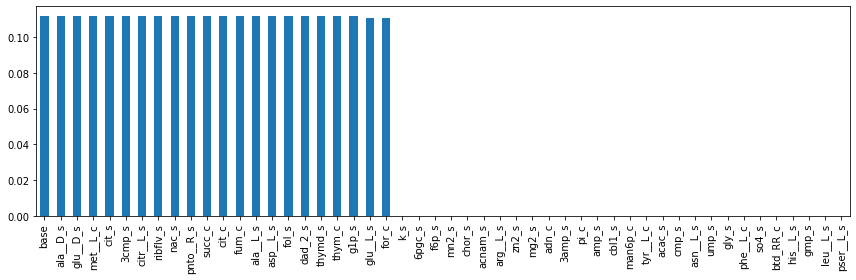

In [53]:
flux_results_df = pd.read_csv('PEP_group_1by1_KO_flux_results.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("PEP_group_1by1_KO_flux_results.svg", format="SVG")

#### Essential mets

In [55]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [56]:
flux_results_df = pd.read_csv('PEP_group_1by1_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True).index.to_list()
essential_mets = sorted_mets[:sorted_mets.index('for_c')+1]
print('Essential metabolites: {}'.format(essential_mets))

Essential metabolites: ['pser__L_s', 'leu__L_s', 'gmp_s', 'his__L_s', 'btd_RR_c', 'so4_s', 'phe__L_c', 'gly_s', 'ump_s', 'asn__L_s', 'cmp_s', 'acac_s', 'tyr__L_c', 'man6p_c', 'cbl1_s', 'amp_s', 'pi_c', '3amp_s', 'adn_c', 'mg2_s', 'zn2_s', 'arg__L_s', 'acnam_s', 'chor_s', 'mn2_s', 'f6p_s', '6pgc_s', 'k_s', 'for_c']


In [57]:
essential_transporters = []
for met in essential_mets:
    [essential_transporters.append(i) for i in at_dict[met]]

In [58]:
print('{} essential open transporters'.format(len(essential_transporters)))

79 essential open transporters


In [59]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [60]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 437.338554 seconds
Finished substituting S,lb,ub in 11.839911 seconds
Finished makeME_LP in 2.265680 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.075 0.075 1
Finished substituting S,lb,ub in 11.849881 seconds
Finished makeME_LP in 2.287160 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.0375 0.0375 1
Finished substituting S,lb,ub in 11.870062 seconds
Finished makeME_LP in 2.283748 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.01875 0.01875 1
Finished substituting S,lb,ub in 11.841204 seconds
Finished makeME_LP in 2.282859 seconds
Getting MINOS parameters from ME_NLP...
4 0.009375 0.009375 0.01875 0.009375 optimal
Finished substituting S,lb,ub in 11.907261 seconds
Finished makeME_LP in 2.274466 seconds
Getting MINOS parameters from ME_NLP...
5 0.014062499999999999 0.014062499999999999 0.01875 0.014062499999999999 optimal
Finished substituting S,lb,ub in 11.743381 seco

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
flux_results_df.to_csv('PEP_essential_metabolite_group_KO.csv')

Chosen change function: group_knockout      Sequential = False


biomass_dilution_s response (20 threads):  34%|███▍      | 10/29 [58:29<19:09, 60.51s/it]    

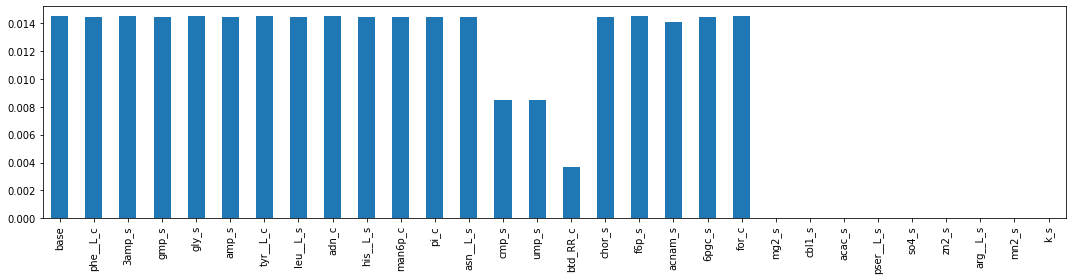

In [66]:
flux_results_df = pd.read_csv('PEP_essential_metabolite_group_KO.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))
plt.tight_layout()
plt.savefig("PEP_essential_metabolite_group_KO.svg", format="SVG")

In [ ]:
flux_results_df = pd.read_csv('PEP_essential_metabolite_group_KO.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))

In [69]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_transporters, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('PEP_essential_transporter_KO.csv')

Chosen change function: transporter      Sequential = False


biomass_dilution_s response (20 threads): 100%|██████████| 79/79 [4:04:56<00:00, 498.11s/it]   

<AxesSubplot:>

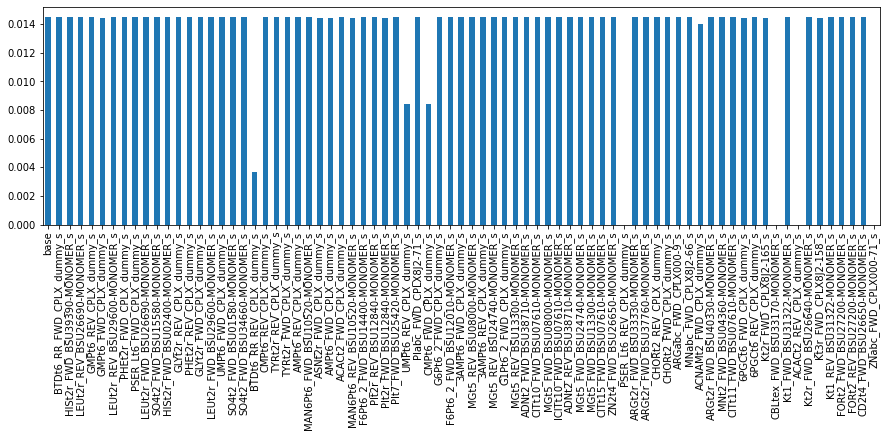

In [70]:
flux_results_df = pd.read_csv('PEP_essential_transporter_KO.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))

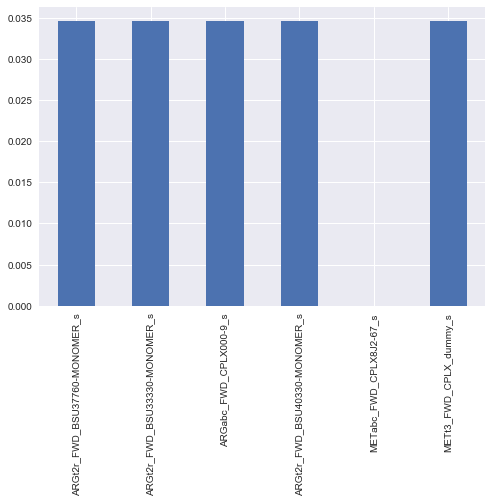

In [53]:
flux_results_df.loc['biomass_dilution_s',at_dict['arg__L_s']+at_dict['met__L_c']].plot.bar()

In [74]:
for r in at_dict['arg__L_s']:
    rxn = sporeme.reactions.get_by_id(r)
    print(rxn.reaction)

arg__L_c + h_c <=> -7.42684631202334e-5*sigma BSU37760-MONOMER_s + arg__L_s + h_s
arg__L_c + h_c <=> -4.27350427350427e-6*sigma BSU33330-MONOMER_s + arg__L_s + h_s
arg__L_c + atp_s + h2o_s <=> -4.27350427350427e-6*sigma CPLX000-9_s + adp_s + arg__L_s + h_s + pi_s
arg__L_c + h_c <=> -4.27350427350427e-6*sigma BSU40330-MONOMER_s + arg__L_s + h_s


### Network visualization

In [67]:
import itertools
import networkx as nx

biomass_dilution_s response (20 threads): 100%|██████████| 29/29 [18:06:45<00:00, 2248.47s/it]


In [71]:
flux_results_df = pd.read_csv('PEP_essential_transporter_KO.csv',index_col=0)

In [72]:
flux_results_df.drop('base',axis=1)

,BTDt6_RR_FWD_CPLX_dummy_s,HISt2r_FWD_BSU39390-MONOMER_s,LEUt2r_REV_BSU26690-MONOMER_s,GMPt6_REV_CPLX_dummy_s,GMPt6_FWD_CPLX_dummy_s,LEUt2r_REV_BSU29600-MONOMER_s,PHEt2r_FWD_CPLX_dummy_s,PSER_Lt6_FWD_CPLX_dummy_s,LEUt2r_FWD_BSU26690-MONOMER_s,SO4t2_FWD_BSU15580-MONOMER_s,...,CBLtex_FWD_BSU33170-MONOMER_s,Kt1_FWD_BSU31322-MONOMER_s,ACACt2_REV_CPLX_dummy_s,Kt2r_FWD_BSU26640-MONOMER_s,Kt3r_FWD_CPLX8J2-158_s,Kt1_REV_BSU31322-MONOMER_s,FORt2_FWD_BSU27200-MONOMER_s,FORt2_REV_BSU27200-MONOMER_s,CD2t4_FWD_BSU26650-MONOMER_s,ZNabc_FWD_CPLX000-71_s
biomass_dilution,0.004487,0.004487,0.004487,0.004487,0.004479,0.004487,0.004487,0.004487,0.004487,0.004487,...,0.0,0.004487,0.0,0.004487,0.004506,0.004487,0.004487,0.004487,0.004487,0.0
protein_biomass_to_biomass,0.002637,0.002637,0.002637,0.002637,0.002632,0.002637,0.002637,0.002637,0.002637,0.002637,...,0.0,0.002637,0.0,0.002637,0.002648,0.002637,0.002637,0.002637,0.002637,0.0
mRNA_biomass_to_biomass,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,...,0.0,0.000007,0.0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.0
tRNA_biomass_to_biomass,0.000043,0.000043,0.000043,0.000043,0.000042,0.000043,0.000043,0.000043,0.000043,0.000043,...,0.0,0.000043,0.0,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.0
rRNA_biomass_to_biomass,0.000315,0.000315,0.000315,0.000315,0.000314,0.000315,0.000315,0.000315,0.000315,0.000315,...,0.0,0.000315,0.0,0.000315,0.000316,0.000315,0.000315,0.000315,0.000315,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demand_psetha_BS_s,0.014476,0.014476,0.014476,0.014476,0.014446,0.014476,0.014476,0.014476,0.014476,0.014476,...,0.0,0.014476,0.0,0.014476,0.014439,0.014476,0.014476,0.014476,0.014476,0.0
Demand_t12dg_BS_s,0.014476,0.014476,0.014476,0.014476,0.014446,0.014476,0.014476,0.014476,0.014476,0.014476,...,0.0,0.014476,0.0,0.014476,0.014439,0.014476,0.014476,0.014476,0.014476,0.0
Demand_gtca3_45_BS_s,0.014476,0.014476,0.014476,0.014476,0.014446,0.014476,0.014476,0.014476,0.014476,0.014476,...,0.0,0.014476,0.0,0.014476,0.014439,0.014476,0.014476,0.014476,0.014476,0.0
Demand_lipo1_24_BS_s,0.014476,0.014476,0.014476,0.014476,0.014446,0.014476,0.014476,0.014476,0.014476,0.014476,...,0.0,0.014476,0.0,0.014476,0.014439,0.014476,0.014476,0.014476,0.014476,0.0


In [73]:
G = nx.Graph()

for r in flux_results_df.drop('base',axis=1).columns:
    rxn = sporeme.reactions.get_by_id(r)
    mets = list(set([m.id[:-2] for m in rxn.metabolites if isinstance(m,cobrame.Metabolite)]))
    combinations = list(itertools.combinations(mets, 2))
    
    for m in mets:
        G.add_node(m,node_size=1000)
    
    for c in combinations:
        G.add_edge(c[0],c[1])

In [74]:
print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
['h', 'btd_RR', 'his__L', 'leu__L', 'gmp', 'phe__L', 'pser__L', 'so4', 'gly', 'ump', 'cmp', 'tyr__L', 'amp', 'man6p', 'asn__L', 'acac', 'pi', 'f6p', 'na1', 'h2o', 'atp', 'adp', 'g6p', '3amp', 'mg2', 'g1p', 'adn', 'cit', 'icit', 'zn2', 'k', 'arg__L', 'chor', 'mn2', 'acnam', '6pgc', 'cbl1', 'for', 'cd2']
Edges of graph: 
[('h', 'btd_RR'), ('h', 'his__L'), ('h', 'leu__L'), ('h', 'gmp'), ('h', 'phe__L'), ('h', 'pser__L'), ('h', 'so4'), ('h', 'gly'), ('h', 'ump'), ('h', 'cmp'), ('h', 'tyr__L'), ('h', 'amp'), ('h', 'man6p'), ('h', 'asn__L'), ('h', 'acac'), ('h', 'pi'), ('h', 'h2o'), ('h', 'atp'), ('h', 'adp'), ('h', '3amp'), ('h', 'adn'), ('h', 'mg2'), ('h', 'cit'), ('h', 'icit'), ('h', 'zn2'), ('h', 'k'), ('h', 'arg__L'), ('h', 'chor'), ('h', 'mn2'), ('h', 'acnam'), ('h', '6pgc'), ('h', 'for'), ('h', 'cd2'), ('pi', 'f6p'), ('pi', 'na1'), ('pi', 'h2o'), ('pi', 'atp'), ('pi', 'adp'), ('pi', 'g6p'), ('pi', 'g1p'), ('pi', 'arg__L'), ('pi', 'mn2'), ('pi', 'zn2'), ('h2o', 'atp'),

In [75]:
G.remove_node('cbl1')

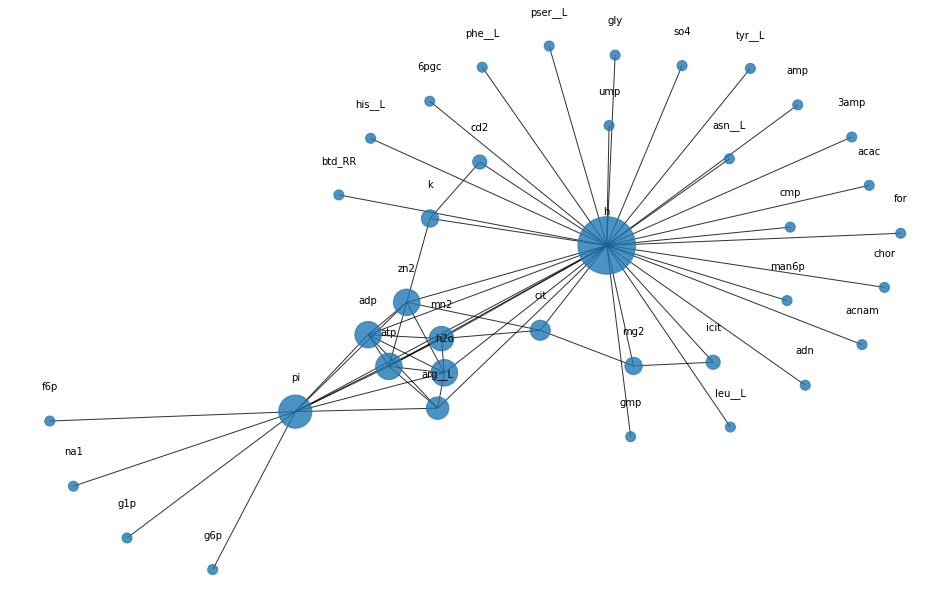

In [76]:
d = dict(G.degree)

pos = nx.spring_layout(G)
plt.figure(figsize=(13,8))
nx.draw(G,pos=pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()],alpha=0.8)

for label in pos.keys():
    x,y = pos[label]
    plt.text(x,y+0.09,s=label,horizontalalignment='center')

plt.draw()
plt.savefig("transport_graph.svg", format="SVG")

#### Cases

In [35]:
flux_results_df = pd.read_csv('PEP_group_1by1_KO_flux_results.csv',index_col=0)
flux_dict = flux_results_df['for_c'].to_dict() # Last time before model breaks

In [21]:
met='atp_s' # Protein synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).sort_values('met_flux')

,lb,ub,rxn_flux,met_flux,reaction
NDPK1_FWD_BSU22730-MONOMER_mod_mn2_s,0,999999,0.950312,-0.950312,atp_s + gdp_s <=> -4.27350427350427e-6*sigma B...
ADK1_FWD_BSU01370-MONOMER_mod_mg2_s,0,999999,0.550753,-0.550753,amp_s + atp_s <=> -4.27350427350427e-6*sigma B...
PC_FWD_BSU14860-MONOMER_s,0,999999,0.189997,-0.189997,atp_s + hco3_s + pyr_s <=> -4.27350427350427e-...
ACCOAC_FWD_CPLX000-1_s,0,999999,0.167228,-0.167228,accoa_s + atp_s + hco3_s <=> -4.27350427350427...
ASPK_FWD_BSU16760-MONOMER_s,0,999999,0.130944,-0.130944,asp__L_s + atp_s <=> 4pasp_s + -4.273504273504...
...,...,...,...,...,...
NDPK2_REV_BSU22730-MONOMER_mod_mn2_s,0,999999,0.0101283,0.0101283,adp_s + utp_s <=> -4.27350427350427e-6*sigma B...
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s,0,999999,0.0342162,0.0342162,amp_s + argsuc_s + h_s + ppi_s <=> -4.27350427...
PGK_REV_BSU33930-MONOMER_s,0,999999,0.245138,0.245138,13dpg_s + adp_s <=> 3pg_s + -2.73961266103634e...
PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s,0,999999,0.591435,0.591435,adp_s + h_s + pep_s <=> -7.24069444255906e-7*s...


In [34]:
sporeme.metabolites.get_by_id('adn_c').name

'Adenosine'

In [27]:
met='h_c' 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).sort_values(by='met_flux',ascending=False).head(10)

,lb,ub,rxn_flux,met_flux,reaction
ADNt2_REV_BSU38710-MONOMER_s,0,999999,181.363,181.363,adn_s + h_s <=> -4.27350427350427e-6*sigma BSU...
MAN6Pt6_REV_BSU10520-MONOMER_s,0,999999,91.451,91.451,h_s + man6p_s <=> -4.27350427350427e-6*sigma B...
ATPS4r_FWD_CPLX000-10,0,999999,10.3809,31.1428,adp_c + 4.0 h_e + pi_c <=> -4.27350427350427e-...
GAPD_FWD_BSU33940-MONOMER,0,999999,2.62972,2.62972,g3p_c + nad_c + pi_c <=> 13dpg_c + -3.09634335...
SUCD5_BS_FWD_CPLX8J2-15,0,999999,0.980736,1.96147,fadh2_c + 2.0 h_e + mqn7_c <=> -1.278571786469...
PFK_FWD_BSU29190-MONOMER,0,999999,1.49912,1.49912,atp_c + f6p_c <=> -4.27350427350427e-6*sigma B...
MDH_FWD_BSU29120-MONOMER,0,999999,1.15295,1.15295,mal__L_c + nad_c <=> -1.93021378209842e-6*sigm...
CS_FWD_BSU29140-MONOMER,0,999999,1.14512,1.14512,accoa_c + h2o_c + oaa_c <=> -1.64233937725983e...
PPA_FWD_BSU40550-MONOMER,0,999999,0.803401,0.803401,h2o_c + ppi_c <=> -0.000101820379163072*sigma ...
HCO3E_FWD_BSU30690-MONOMER_mod_zn2,0,999999,0.417303,0.417303,co2_c + h2o_c <=> -3.32710184601155e-6*sigma B...


In [33]:
met='3amp_c' 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
3AMPt6_FWD_CPLX_dummy_s,0,999999,181.363,-181.363,3amp_c + h_c <=> 3amp_s + -4.27350427350427e-6...
3NUCLE1_REV_BSU07840-MONOMER,0,999999,181.363,181.363,adn_c + pi_c <=> 3amp_c + -4.27350427350427e-6...
3AMPt6_FWD_CPLX_dummy,0,999999,0,0,3amp_e + h_e <=> 3amp_c + -4.27350427350427e-6...
3AMPt6_REV_CPLX_dummy_s,0,999999,0,0,3amp_s + h_s <=> 3amp_c + -4.27350427350427e-6...
3AMPt6_REV_CPLX_dummy,0,999999,0,-0,3amp_c + h_c <=> 3amp_e + -4.27350427350427e-6...
23CN2P1_REV_BSU07840-MONOMER,0,999999,0,-0,3amp_c + h_c <=> 23camp_c + -4.27350427350427e...
23CN2P1_FWD_BSU07840-MONOMER,0,999999,0,0,23camp_c + h2o_c <=> 3amp_c + -4.2735042735042...
3NUCLE1_FWD_BSU07840-MONOMER,0,999999,0,-0,3amp_c + h2o_c <=> -4.27350427350427e-6*sigma ...


In [135]:
sporeme.reactions.get_by_id('PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s').reaction

'adp_s + h_s + pep_s <=> -7.24069444255906e-7*sigma BSU29180-MONOMER_mod_mn2_mod_k_s + atp_s + pyr_s'

In [29]:
met='pep_s' # ATP production and glucose uptake
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [14]:
met='cit_s'
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [15]:
met='met__L_s' # Protein synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [94]:
met='so4_s' # Protein synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
SADT_FWD_BSU15590-MONOMER_s,0,999999,0.0158481,-0.0158481,atp_s + h_s + so4_s <=> -4.27350427350427e-6*s...
SO4t2_FWD_BSU15580-MONOMER_s,0,999999,0.0158481,0.0158481,h_c + so4_c <=> -4.27350427350427e-6*sigma BSU...
SO4t2_FWD_BSU34660-MONOMER_s,0,999999,0,0,h_c + so4_c <=> -6.86674718898359e-5*sigma BSU...
SADT_REV_BSU15590-MONOMER_s,0,999999,0,0,aps_s + ppi_s <=> -4.27350427350427e-6*sigma B...
SO4t2_FWD_BSU01580-MONOMER_s,0,999999,0,0,h_c + so4_c <=> -4.27350427350427e-6*sigma BSU...


In [95]:
met='btd_RR_c' # Ornithine synthesis, ArgSuc synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
BTDt6_RR_FWD_CPLX_dummy,0,999999,0,0,btd_RR_e + h_e <=> -4.27350427350427e-6*sigma ...
BTDD_RR_REV_BSU06240-MONOMER,0,999999,0,0,actn__R_c + h_c + nadh_c <=> -3.00246548499129...
BTDt6_RR_REV_CPLX_dummy,0,999999,0,-0,btd_RR_c + h_c <=> -4.27350427350427e-6*sigma ...
BTDt6_RR_FWD_CPLX_dummy_s,0,999999,0,-0,btd_RR_c + h_c <=> -4.27350427350427e-6*sigma ...
BTDD_RR_FWD_BSU06240-MONOMER,0,999999,0,-0,btd_RR_c + nad_c <=> -3.00246548499129e-6*sigm...
BTDt6_RR_REV_CPLX_dummy_s,0,999999,0,0,btd_RR_s + h_s <=> -4.27350427350427e-6*sigma ...


In [36]:
met='argsuc_s' # Citruline synthesis.  Urea cycle and the synthesis of pyrimidines: nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [37]:
met='citr__L_s' # Carbamoyl phosphate and ornithine synthesis.  Urea cycle and the synthesis of pyrimidines: nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [21]:
met='pser__L_s' # Glutamate synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [22]:
met='asp__L_s' # Production of 4asp
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [23]:
met='gmp_s' # Nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [24]:
met='acnam_s' # A fraction of PEP_s requirement in the spore
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [27]:
met='3amp_s' # Pumping phosporus Pi C->S. Pi is used to pump Fructose C->S
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [29]:
met='f6p_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [30]:
met='man6p_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [34]:
met='h_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [71]:
met='pi_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
F6Pt6_2_FWD_BSU12010-MONOMER_s,0,999999,90.4033,-180.807,f6p_c + 2.0 pi_s <=> -4.27350427350427e-6*sigm...
3NUCLE1_FWD_BSU07840-MONOMER_s,0,999999,179.642,179.642,3amp_s + h2o_s <=> -4.27350427350427e-6*sigma ...
ATPS4r_FWD_CPLX000-10_s,0,999999,23.0471,-23.0471,adp_s + 4.0 h_c + pi_s <=> -4.27350427350427e-...
PPA_FWD_BSU40550-MONOMER_s,0,999999,0.769643,1.53929,h2o_s + ppi_s <=> -0.000101820379163072*sigma ...
ACCOAC_FWD_CPLX000-1_s,0,999999,0.168744,0.168744,accoa_s + atp_s + hco3_s <=> -4.27350427350427...
...,...,...,...,...,...
OCBT_1_FWD_BSU11250-MONOMER_s,0,999999,0,0,cbp_s + orn__L_s <=> -1.39331395579107e-5*sigm...
LANTHabc_FWD_CPLX_dummy_s,0,999999,0,0,atp_s + h2o_s + lanth_c <=> -4.27350427350427e...
MALTTRabc_FWD_CPLX_dummy_s,0,999999,0,0,atp_s + h2o_s + malttr_c <=> -4.27350427350427...
MSO3abc_FWD_CPLX8J2-74_s,0,999999,0,0,atp_s + h2o_s + mso3_c <=> -4.27350427350427e-...


In [64]:
sporeme.reactions.get_by_id('3AMPt6_FWD_CPLX_dummy_s').reaction

'3amp_c + h_c <=> 3amp_s + -4.27350427350427e-6*sigma CPLX_dummy_s + h_s'

In [66]:
sporeme.reactions.get_by_id('3NUCLE1_FWD_BSU07840-MONOMER_s').reaction

'3amp_s + h2o_s <=> -4.27350427350427e-6*sigma BSU07840-MONOMER_s + adn_s + pi_s'

In [68]:
sporeme.reactions.get_by_id('ADNt2_REV_BSU38710-MONOMER_s').reaction

'adn_s + h_s <=> -4.27350427350427e-6*sigma BSU38710-MONOMER_s + adn_c + h_c'

In [70]:
sporeme.reactions.get_by_id('3NUCLE1_REV_BSU07840-MONOMER').reaction

'adn_c + pi_c <=> 3amp_c + -4.27350427350427e-6*sigma BSU07840-MONOMER + h2o_c'

In [122]:
sporeme.metabolites.get_by_id('6pgc_s').name

'6-Phospho-D-gluconate'

In [26]:
met='adn_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [28]:
met='pi_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [51]:
met='leu__L_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='glu__L_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [53]:
met='orn__L_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

#### Pairwise interaction

In [96]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [97]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [98]:
flux_results_df = pd.read_csv('essential_metabolite_group_KO.csv',index_col=0)
essential_metabolites = flux_results_df.drop('base',axis=1).columns.values
base_model = copy.deepcopy(sporeme)

In [99]:
from scipy.special import binom
print('With {} knockouts there can be {} pairs'.format(len(essential_metabolites),binom(len(essential_metabolites),2)))

With 21 knockouts there can be 210.0 pairs


In [ ]:
from bacillusme.analysis import sensitivity as ss
for met in essential_metabolites:
    # Restore
    sporeme = copy.deepcopy(base_model)
    
    # Close transporter
    for r in at_dict[met]:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.lower_bound = 0
        rxn.upper_bound = 0
    
    # Calculation
    flux_results_df = ss.transporter_knockout(sporeme,essential_metabolites, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
    flux_results_df.to_csv('group_transporter_knockouts/{}.csv'.format(met))

Chosen change function: group_knockout      Sequential = False
























  0%|          | 0/21 [00:00<?, ?it/s]





















biomass_dilution_s response (20 threads):   0%|          | 0/21 [00:00<?, ?it/s]

In [102]:
flux_results_df

,base,arg__L_s,zn2_s,so4_s,acnam_s,pser__L_s,6pgc_s,asp__L_s,k_s,gmp_s,...,pyr_c,cbl1_s,mg2_s,pi_c,3amp_s,adn_c,man6p_c,mn2_s,f6p_s,met__L_c
biomass_dilution,0.046832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
protein_biomass_to_biomass,0.026954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mRNA_biomass_to_biomass,0.000092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tRNA_biomass_to_biomass,0.000544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rRNA_biomass_to_biomass,0.004027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demand_psetha_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_t12dg_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_gtca3_45_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_lipo1_24_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Read and process
gr_df = pd.DataFrame(index=essential_metabolites)
for m in essential_metabolites:
    flux_results_df=pd.read_csv('group_transporter_knockouts/{}.csv'.format(m),index_col=0).drop('base',axis=1)
    for i in flux_results_df.columns.values:
        gr_df.loc[m,i] = flux_results_df.loc['biomass_dilution_s',i]

<Figure size 936x360 with 0 Axes>

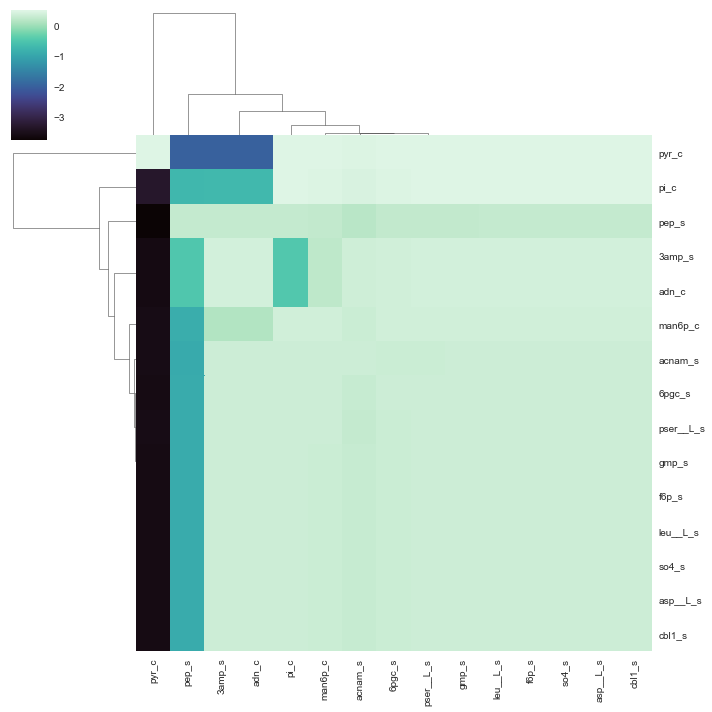

In [105]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)]
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako')

<Figure size 936x360 with 0 Axes>

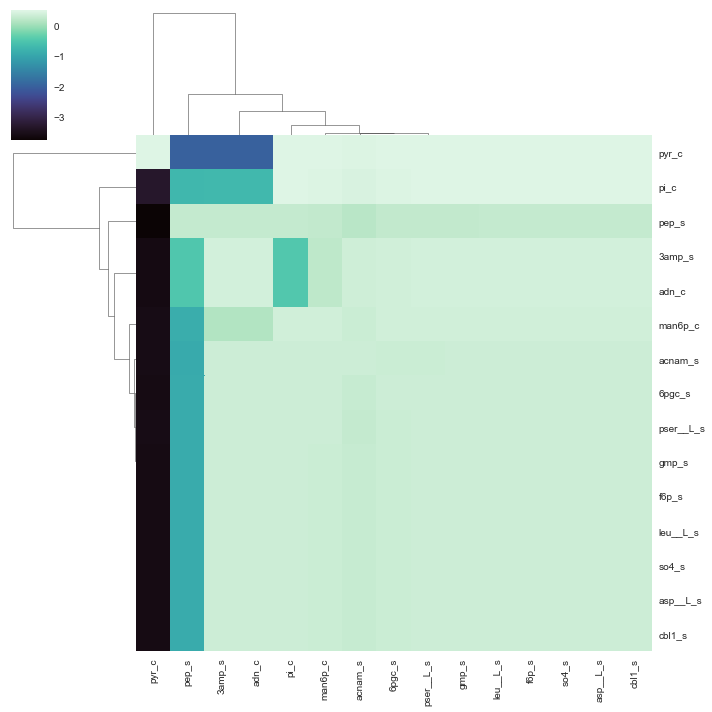

In [111]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)]
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako')

## Energy analysis

In [188]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [189]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True).index.to_list()
essential_mets = sorted_mets[:sorted_mets.index('met__L_c')+1]
print('Essential metabolites: {}'.format(essential_mets))

Essential metabolites: ['arg__L_s', 'zn2_s', '6pgc_s', 'so4_s', 'mg2_s', 'pi_c', 'cbl1_s', 'asp__L_s', 'f6p_s', 'mn2_s', 'adn_c', 'acnam_s', 'pep_s', 'pyr_c', 'k_s', 'pser__L_s', 'man6p_c', 'gmp_s', 'leu__L_s', '3amp_s', 'met__L_c']


In [190]:
essential_transporters = []
for met in essential_mets:
    [essential_transporters.append(i) for i in at_dict[met]]

In [191]:
print('{} essential open transporters'.format(len(essential_transporters)))

63 essential open transporters


In [192]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')
flux_dict_base = sporeme.solution.x_dict

iter	muopt    	a     	b     	mu1       	stat1


### Increasing ATPM

In [ ]:
current_ATPM = sporeme.reactions.ATPM_s.lower_bound
new_ATPM = 1.1 * current_ATPM

sporeme.reactions.ATPM_s.lower_bound = new_ATPM
sporeme.reactions.ATPM_s.upper_bound = new_ATPM

In [177]:
solve_me_model(sporeme, max_mu = 0.2, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key='sigma')
flux_dict_ATPM = sporeme.solution.x_dict

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 415.296403 seconds
Finished substituting S,lb,ub in 18.126293 seconds
Finished makeME_LP in 2.265234 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.1 0.1 1
Finished substituting S,lb,ub in 18.146298 seconds
Finished makeME_LP in 2.297373 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 18.020615 seconds
Finished makeME_LP in 2.269276 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.025 0.025 1
Finished substituting S,lb,ub in 17.943079 seconds
Finished makeME_LP in 2.261524 seconds
Getting MINOS parameters from ME_NLP...
4 0.0125 0.0125 0.025 0.0125 optimal
Finished substituting S,lb,ub in 17.930481 seconds
Finished makeME_LP in 2.260695 seconds
Getting MINOS parameters from ME_NLP...
5 0.0125 0.0125 0.018750000000000003 0.018750000000000003 1
Finished substituting S,lb,ub in 18.196980 seconds
Finished makeME_LP in 2.283978 second

In [199]:
atp_df = pd.DataFrame.from_dict({'flux':flux_dict_base}).join(pd.DataFrame.from_dict({'flux':flux_dict_ATPM}),rsuffix='_atp')
atp_df.loc['ATPM_s']

flux        11.979
flux_atp     9.900
Name: ATPM_s, dtype: float64

In [215]:
sums = atp_df.loc[at_dict[met]].sum(axis=0)
sums.any()

True

## 

In [218]:

for met in at_dict.keys():
    sums = atp_df.loc[at_dict[met]].sum(axis=0)
    if sums.any():
        ratio = sums['flux_atp']/sums['flux']
        print(met,ratio)

mg2_s 1.369556359552247
gmp_s 1.3936761015209471
pyr_c 0.9235568354626225
k_s 1.402986049062581
man6p_c 1.4041387607925155
arg__L_s 1.3820070949439316
met__L_c 1.3367661897406746
mn2_s 1.3274067919517458
acnam_s 1.410649664782645
pep_s 0.9219755938517683
so4_s 1.3508168559868865
zn2_s 1.9776180944903203
adn_c 0.9206735465435527
3amp_s 0.9206362189827443
pser__L_s 1.431980366328135
6pgc_s 1.404908804372569
leu__L_s 1.3894840437357847


## Metabolites in medium

In [ ]:
[fed_mets = m for m in at_dict.keys() if m]

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,fed_mets, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='feed_metabolites')

Chosen change function: feed_metabolites      Sequential = False














































  0%|          | 0/38 [00:00<?, ?it/s]











































biomass_dilution_s response (10 threads):   0%|          | 0/38 [00:00<?, ?it/s]

In [225]:
flux_results_df

,base,gly_s,nac_s,cit_s,amp_s,citr__L_s,asn__L_s,acac_s,cmp_s,ump_s,...,ala__D_s,glu__L_s,pnto__R_s,dad_2_s,ribflv_s,3amp_s,ala__L_s,6pgc_s,pser__L_s,leu__L_s
biomass_dilution,0.012078,0.012073,0.012052,0.012060,0.012035,0.012056,0.012061,0.012064,0.012043,0.012044,...,0.012067,0.012055,0.012034,0.012034,0.011992,0.012036,0.012067,0.012054,0.012067,0.012050
protein_biomass_to_biomass,0.007074,0.007072,0.007059,0.007064,0.007049,0.007061,0.007065,0.007066,0.007054,0.007055,...,0.007068,0.007061,0.007049,0.007049,0.007024,0.007050,0.007068,0.007060,0.007068,0.007058
mRNA_biomass_to_biomass,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020
tRNA_biomass_to_biomass,0.000119,0.000119,0.000119,0.000119,0.000118,0.000119,0.000119,0.000119,0.000118,0.000118,...,0.000119,0.000119,0.000118,0.000118,0.000118,0.000118,0.000119,0.000119,0.000119,0.000119
rRNA_biomass_to_biomass,0.000879,0.000879,0.000877,0.000878,0.000876,0.000877,0.000878,0.000878,0.000876,0.000876,...,0.000878,0.000877,0.000876,0.000876,0.000872,0.000876,0.000878,0.000877,0.000878,0.000877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demand_t12dg_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_gtca3_45_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_lipo1_24_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_tcam_BS_s,0.539554,0.539392,0.538664,0.538933,0.537795,0.538743,0.538900,0.539076,0.538259,0.538332,...,0.539224,0.538640,0.537977,0.537838,0.536119,0.537875,0.539226,0.538711,0.539156,0.538619
